In [16]:
import pandas as pd
import pandas_ta as ta

df = pd.read_csv("EURUSD_Candlestick_5_M_ASK_30.09.2019-30.09.2022.csv")
df["Gmt time"]=df["Gmt time"].str.replace(".000","")
df['Gmt time']=pd.to_datetime(df['Gmt time'],format='%d.%m.%Y %H:%M:%S')
df=df[df.High!=df.Low]
df.set_index("Gmt time", inplace=True)

df["EMA"]=ta.ema(df.Close, length=30)
df['RSI']=ta.rsi(df.Close, length=10)
my_bbands = ta.bbands(df.Close, length=15, std=1.5)
df['ATR']=ta.atr(df.High, df.Low, df.Close, length=7)
df=df.join(my_bbands)
df.head()

,Open,High,Low,Close,Volume,EMA,RSI,ATR,BBL_15_1.5,BBM_15_1.5,BBU_15_1.5,BBB_15_1.5,BBP_15_1.5
Gmt time,,,,,,,,,,,,,
2019-09-30 00:00:00,1.09425,1.09426,1.09405,1.09406,585.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-30 00:05:00,1.09408,1.09414,1.09401,1.09409,289.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-30 00:10:00,1.09410,1.09423,1.09408,1.09410,276.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-30 00:15:00,1.09409,1.09410,1.09388,1.09389,439.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-30 00:20:00,1.09390,1.09395,1.09388,1.09395,341.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
def ema_signal(df, current_candle, backcandles):
    df_slice = df.copy()
    df_slice = df_slice.loc[current_candle-backcandles:current_candle, ["Open", "Close", "EMA"]]
    # among all rows, dnt/upt = 0 if there's any row that disobey the EMA rules
    dnt = 0 if (df_slice[["Open", "Close"]].max(axis=1) >= df_slice["EMA"]).any() else 1
    upt = 0 if (df_slice[["Open", "Close"]].min(axis=1) <= df_slice["EMA"]).any() else 1

    if upt==1 and dnt==1:
        return 3
    # long signal
    elif upt==1:
        return 2
    # short signal
    elif dnt==1:
        return 1
    else:
        return 0

df=df[-10000:-1]
#ema_signal(df, 1313, 5)
from tqdm import tqdm
tqdm.pandas()
df.reset_index(inplace=True)
#df['EMASignal'] = df.progress_apply(lambda row: ema_signal(df, row.name, 5) if row.name >= 20 else 0, axis=1)
def total_signal(df, current_candle, backcandles):
    if (ema_signal(df, current_candle, backcandles)==2
        and df.Close[current_candle]<=df['BBL_15_1.5'][current_candle]
        #and df.RSI[current_candle]<60
        ):
            return 2
    if (ema_signal(df, current_candle, backcandles)==1
        and df.Close[current_candle]>=df['BBU_15_1.5'][current_candle]
        #and df.RSI[current_candle]>40
        ):
    
            return 1
    return 0
        
df['TotalSignal'] = df.progress_apply(lambda row: total_signal(df, row.name, 7), axis=1)

100%|██████████| 9995/9995 [00:59<00:00, 169.35it/s]


In [23]:
df

,index,Gmt time,Open,High,Low,Close,Volume,EMA,RSI,ATR,BBL_15_1.5,BBM_15_1.5,BBU_15_1.5,BBB_15_1.5,BBP_15_1.5,TotalSignal
0,0,2022-08-15 03:10:00,1.02454,1.02482,1.02454,1.02471,843.52,1.025086,46.250354,0.000317,1.024201,1.024601,1.025002,0.078120,0.635763,0
1,1,2022-08-15 03:15:00,1.02470,1.02478,1.02455,1.02468,1139.19,1.025059,45.394071,0.000305,1.024227,1.024572,1.024917,0.067283,0.656666,0
2,2,2022-08-15 03:20:00,1.02468,1.02481,1.02466,1.02478,733.53,1.025041,48.898158,0.000283,1.024243,1.024559,1.024875,0.061707,0.850088,0
3,3,2022-08-15 03:25:00,1.02478,1.02492,1.02474,1.02487,723.19,1.025030,51.979645,0.000268,1.024246,1.024556,1.024866,0.060462,1.006890,1
4,4,2022-08-15 03:30:00,1.02486,1.02498,1.02478,1.02478,766.65,1.025014,48.715648,0.000258,1.024245,1.024564,1.024883,0.062250,0.838670,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,9990,2022-09-30 20:10:00,0.98071,0.98103,0.98058,0.98086,484.52,0.980036,64.848459,0.000511,0.979550,0.980140,0.980730,0.120337,1.110441,0
9991,9991,2022-09-30 20:15:00,0.98086,0.98092,0.98072,0.98074,363.82,0.980081,61.415703,0.000466,0.979551,0.980139,0.980728,0.120023,1.010601,0
9992,9992,2022-09-30 20:20:00,0.98075,0.98086,0.98064,0.98064,303.07,0.980117,58.546127,0.000431,0.979564,0.980179,0.980795,0.125532,0.874393,0
9993,9993,2022-09-30 20:25:00,0.98065,0.98094,0.98062,0.98085,385.85,0.980165,62.621243,0.000415,0.979581,0.980238,0.980895,0.134049,0.965755,0


In [26]:
# df[df.TotalSignal != 0].head(10)

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
st=100
dfpl = df[st:st+350]
#dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close']),

                go.Scatter(x=dfpl.index, y=dfpl['BBL_15_1.5'], 
                           line=dict(color='green', width=1), 
                           name="BBL"),
                go.Scatter(x=dfpl.index, y=dfpl['BBU_15_1.5'], 
                           line=dict(color='green', width=1), 
                           name="BBU"),
                go.Scatter(x=dfpl.index, y=dfpl['EMA'], 
                           line=dict(color='black', width=1), 
                           name="EMA")           ])

# fig.show()


In [27]:
from backtesting import Strategy
from backtesting import Backtest
def SIGNAL():
    return df.TotalSignal
class MyStrat(Strategy):
    mysize = 0.99
    slcoef = 1.2 #1.3
    TPSLRatio = 2 # 1.8
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio

        if len(self.trades)>0:
            if self.trades[-1].is_long and self.data.RSI[-1]>=90:
                self.trades[-1].close()
            elif self.trades[-1].is_short and self.data.RSI[-1]<=10:
                self.trades[-1].close()
        
        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
        
        elif self.signal1==1 and len(self.trades)==0:         
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(df, MyStrat, cash=250, margin=1/30, commission=0.00)
stats, heatmap = bt.optimize(slcoef=[i/10 for i in range(10, 21)],
                    TPSLRatio=[i/10 for i in range(10, 21)], 
                    maximize='Return [%]', max_tries=300,
                        random_state=0,
                        return_heatmap=True)
stats

C:\Users\p3749\AppData\Local\Temp\ipykernel_33052\2180651222.py:33: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Start                                     0.0
End                                    9994.0
Duration                               9994.0
Exposure Time [%]                    5.572786
Equity Final [$]                   403.837337
Equity Peak [$]                    403.837337
Return [%]                          61.534935
Buy & Hold Return [%]               -4.335861
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -11.609208
Avg. Drawdown [%]                   -2.504719
Max. Drawdown Duration                 2941.0
Avg. Drawdown Duration             245.148148
# Trades                                 52.0
Win Rate [%]                        42.307692
Best Trade [%]                       0.334812
Worst Trade [%]                     -0.096147
Avg. Trade [%]                    

In [11]:
bt.run()
bt.plot()

stats["_strategy"]

c:\Users\p3749\AppData\Local\Programs\Python\Python311\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

c:\Users\p3749\AppData\Local\Programs\Python\Python311\Lib\site-packages\backtesting\_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



<Strategy MyStrat(slcoef=1.2,TPSLRatio=2.0)>

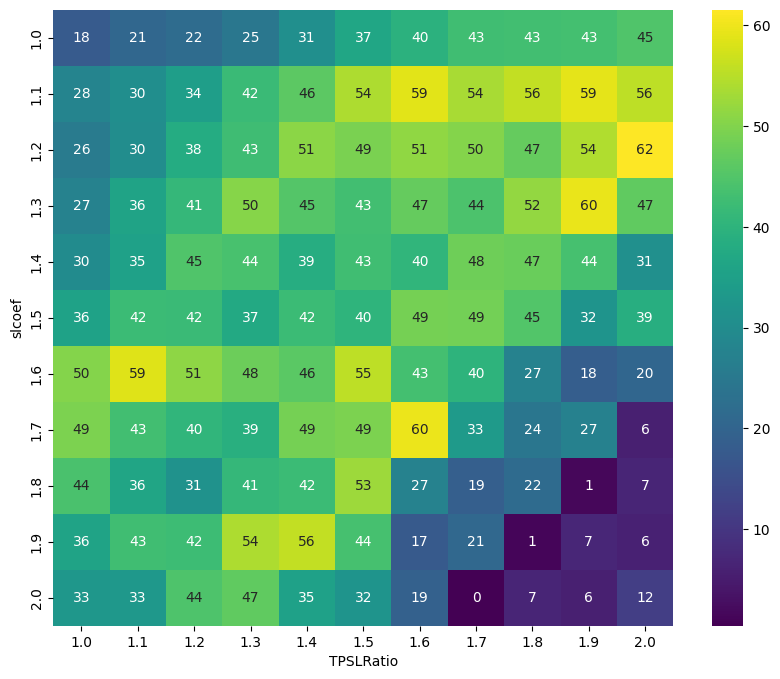

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()